In [1]:
# imports
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
from icecream import ic 
from datetime import datetime
import random
from tqdm import tqdm

# Custom function to format ic prefix 
def ic_prefix():
    timestamp = datetime.now().strftime("%H:%M:%S")
    prefix = f"{timestamp}|>  "
    return prefix

# Set icecream prefix to custom function
ic.configureOutput(prefix=ic_prefix)

In [2]:
# import dataset and pandas df init

cifar_train, cifar_test = load_dataset("cifar100", split = ["train", "test"])
ic(cifar_train.shape, cifar_test.shape)

# pandas df 
# cifar_train_pandas = cifar_train.to_pandas()
cifar_train_pandas = []
for sample in cifar_train:
    cifar_train_pandas.append({
        "img": sample["img"],
        "coarse_label": sample["coarse_label"], 
        "fine_label": sample["fine_label"],
    })
# Convert the list of dictionaries to a Pandas DataFrame
cifar_train_pandas = pd.DataFrame(cifar_train_pandas)
cifar_train_pandas.head()

15:36:39|>  cifar_train.shape: (50000, 3)
            cifar_test.shape: (10000, 3)


,img,coarse_label,fine_label
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,11,19
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,15,29
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,4,0
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,14,11
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,1,1


In [3]:
# DAG init

H = nx.DiGraph()
H.add_node("Root")
    
# add all the nodes

# 1     "Root":                     {"dir_alpha_prior":[...]} --> 
# 20    coarse:                     {"dir_beta_prior": [...]} --> 
# 100   f"{coarse}_{fine}":         {} --> 
# 50000 f"{coarse}_{fine}_{index}:  {"img_data": ..., "label": ...}

# = 50121 nodes 

for i in range(len(cifar_train_pandas)): 
    r = cifar_train_pandas.iloc[i]
    
    img_data = r['img']#.tobytes()
    coarse = r['coarse_label']
    fine = r['fine_label']
    
    label = f"{coarse}_{fine}"
    id = f"{label}_{i}"
    node_attributes = {"img_data":img_data, "label":label}
    
    H.add_node(id, **node_attributes)
    
    if H.has_node(coarse): # has coarse => if has fine then just add the img, otherwise add fine, add img and link properly
        if H.has_node(label):
            H.add_edge(label, id)
        else: 
            H.add_edge(coarse, label)
            H.add_edge(label, id)
    else: 
        H.add_edge("Root", coarse)
        H.add_edge(coarse, label)
        H.add_edge(label, id)
        
alpha = 0.1
beta  = 10
        
# Dir(alpha) prior over the coarse labels
H.nodes["Root"]["dir_alpha_prior"] = np.random.dirichlet(alpha=np.full(len(list(H.successors("Root"))), alpha))

# Dir(beta) priors over the fine labels
for c in list(H.successors("Root")): 
    H.nodes[c]["dir_beta_prior"] = np.random.dirichlet(alpha=np.full(len(list(H.successors(c))), beta))
    
    
_ = ic(H.number_of_nodes()) # 50121, ok!

15:36:47|>  H.number_of_nodes(): 50121


In [4]:
def renormalize(arr, i):
    result = np.delete(arr, i)
    remaining_sum = np.sum(result)
    if remaining_sum != 0:
        result = result / remaining_sum
    return result


M = 500
N = 100

all_clients_datasets = []

for m in tqdm(range(M)):
    c_mult = np.random.dirichlet(alpha=np.full(len(list(H.successors("Root"))), alpha))
    
    f_mult = [] # array of distributions ovet the fine labels (one distr per each coarse)
    for c in range(20):
        if c in list(H.successors("Root")): 
            f_mult.append(np.random.dirichlet(alpha=np.full(len(list(H.successors(c))), beta))) 
        else:
            f_mult.append([]) # this is done because otherwise f_mult matrix would get shorter (fewer rows) while iterating and since c_sampled can always be a number in [0-19], then I wouldn't know what row of this matrix to update. 
                                # appending this empty list keeps the other (surviving) multinomials at their place so that they can be indexed correctly with c_sampled
                                
    Dms = []
    while len(Dms) < N:
        c_sampled = np.random.choice(list(H.successors("Root")), p=c_mult) # [0-19]
        f_sampled = np.random.choice(list(H.successors(c_sampled)), p=f_mult[c_sampled]) # f"{coarse}_{fine}"
            
        leaf_sampled = random.choice(list(H.successors(f_sampled))) # f"{coarse}_{fine}_{dfindex}"
        Dms.append([H.nodes[leaf_sampled]["img_data"], H.nodes[leaf_sampled]["label"]])
        H.remove_node(leaf_sampled)
        
        if len(list(H.successors(f_sampled))) == 0 : 
            # renormalize the prior on the fine
            H.nodes[c_sampled]["dir_beta_prior"] = renormalize(H.nodes[c_sampled]["dir_beta_prior"], list(H.successors(c_sampled)).index(f_sampled))
            # renormalize the mult on the fine
            f_mult[c_sampled] = renormalize(f_mult[c_sampled], list(H.successors(c_sampled)).index(f_sampled))
            H.remove_node(f_sampled)
            
            if len(list(H.successors(c_sampled))) == 0 : 
                # renormalize the prior on the coarse
                H.nodes["Root"]["dir_alpha_prior"] = renormalize(H.nodes["Root"]["dir_alpha_prior"], list(H.successors("Root")).index(c_sampled))
                # renormalize the mult
                c_mult = renormalize(c_mult, list(H.successors("Root")).index(c_sampled))
                H.remove_node(c_sampled)
                
    all_clients_datasets.append(Dms)
    
_ = ic(len(all_clients_datasets), [len(c) for c in all_clients_datasets if len(c)!= 100]) # (500, []) nice! 

100%|██████████| 500/500 [00:02<00:00, 226.11it/s]
15:36:49|>  len(all_clients_datasets): 500
            [len(c) for c in all_clients_datasets if len(c)!= 100]: []


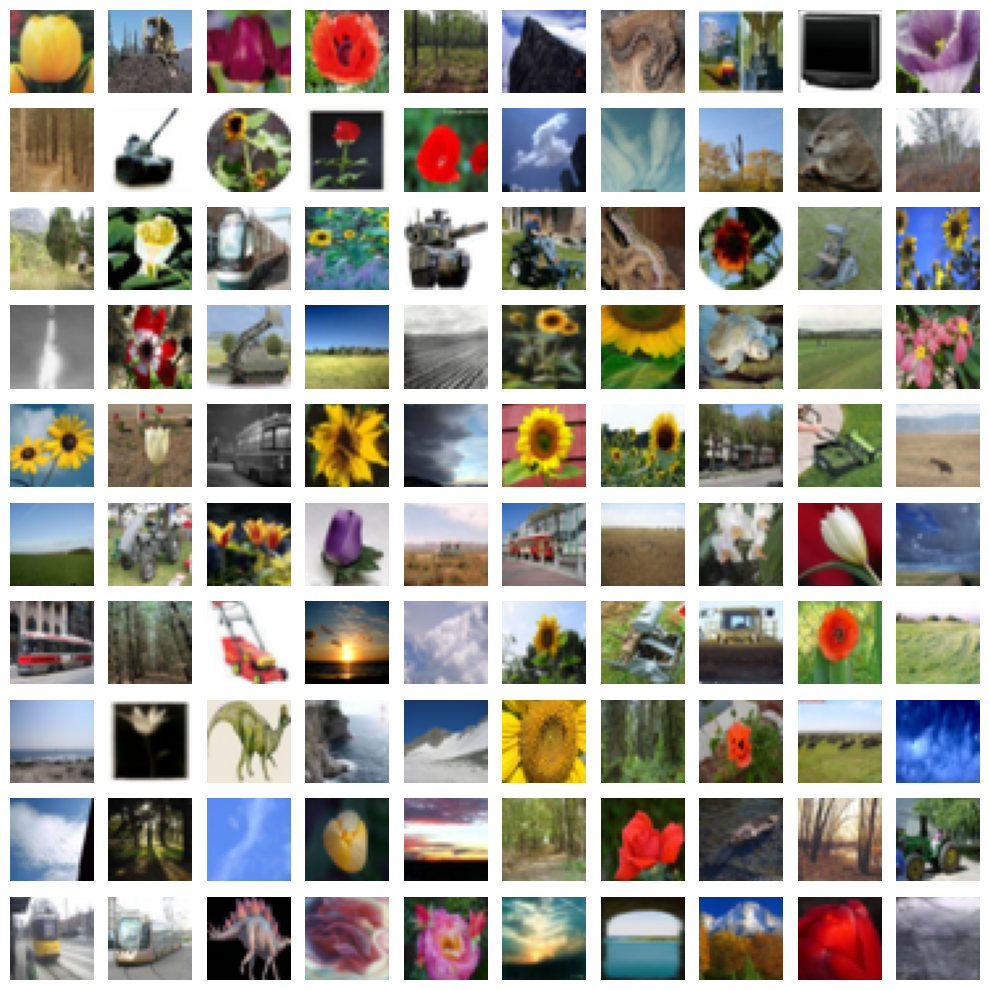

In [5]:
# print the images of the first client, just for fun 
def print_single_client_images(n, all_clients_datasets):
    client = all_clients_datasets[n]
    images = [single_data[0] for single_data in client]

    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(len(images)):
        r = i//10
        c = i%10
        image_data = images[i]
        axes[r,c].imshow(image_data)
        axes[r,c].axis('off')
    plt.tight_layout()
    plt.show()  
    
print_single_client_images(0,all_clients_datasets)

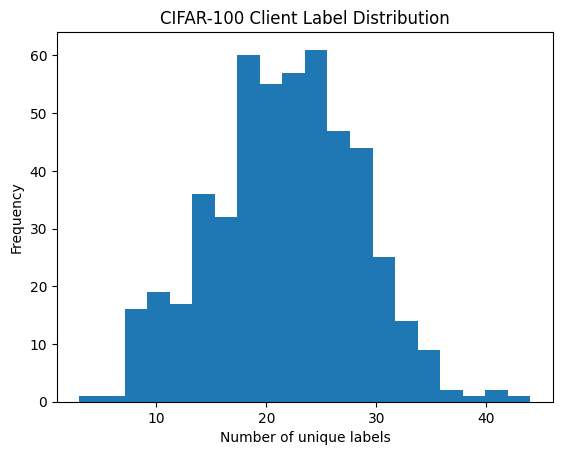

In [6]:
# here we want to reproduce the same histogram at the end of the paper, which is about how many unique labels the clients contain

uniques = [ len(set([all_clients_datasets[i][j][1] for j in range(len(all_clients_datasets[i]))])) for i in range(len(all_clients_datasets))]

plt.hist(uniques, bins=20)
plt.title("CIFAR-100 Client Label Distribution")
plt.xlabel("Number of unique labels")
plt.ylabel("Frequency")
plt.show() # kind of, it is dependant on the specific run.